# 1. Постановка задачи 

По данным о пробах нефти и скважинах в 3-ех регионах требуется построить модель для определения региона, где добыча нефти принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой Bootstrap.

Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах: 
/datasets/geo_data_0.csv. 
/datasets/geo_data_1.csv. 
/datasets/geo_data_2.csv. 

id — уникальный идентификатор скважины;  
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  
product — объём запасов в скважине (тыс. баррелей).  

**Условия задачи:**  

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).  
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
- Бюджет на разработку скважин в регионе — 10 млрд рублей.  
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью. 

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.  

# 2. Загрузка и предобработка данных 

## 2.1 Импорт библиотек и загрузка данных

**Импорт библиотек**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, f1_score, log_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy import stats as st

**Импорт данных**

In [2]:
def read_data_set(pth1, pth2) -> pd.DataFrame:
    df = pd.DataFrame    
    try:
        df = pd.read_csv(pth1)
    except OSError as e:
        df = pd.read_csv(pth2)
    return df

In [3]:
pth1 = ['datasets/geo_data_0.csv', 'datasets/geo_data_1.csv', 'datasets/geo_data_2.csv']
pth2 = (['https://code.s3.yandex.net/datasets/geo_data_0.csv', 'https://code.s3.yandex.net/datasets/geo_data_1.csv',
         'https://code.s3.yandex.net/datasets/geo_data_2.csv'])

In [4]:
df0 = read_data_set(pth1[0], pth2[0]);
df1 = read_data_set(pth1[1], pth2[1]);
df2 = read_data_set(pth1[2], pth2[2]);

**Проверка импорта данных**

In [5]:
df0.info()
df0.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
35556,naguK,0.989348,0.408365,5.607166,132.682983
1801,xo8Vo,0.826453,0.376480,3.841721,68.287483
61741,KQY0v,1.268547,-0.632729,2.151605,181.683567
31670,Igvhv,0.306326,0.016606,3.365159,100.485455
56319,ojlA3,0.827475,0.489170,0.976850,103.303097


## 2.2 Предобработка данных

In [6]:
df0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [7]:
df0.duplicated().sum()

0

In [8]:
df1.info()
df1.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
31132,ikw6y,8.621909,2.323338,2.002572,53.906522
56080,ciUBt,7.743088,-6.465719,3.997740,107.813044
2018,ApizE,-14.537875,-2.667378,4.001069,110.992147
11488,9B3TQ,6.399290,0.072018,4.003013,107.813044
35430,EtVPj,11.351907,-2.218216,1.990380,53.906522


In [9]:
df1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [10]:
df1.duplicated().sum()

0

In [11]:
df2.info()
df2.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
96233,yHFks,1.793412,-0.844903,9.836457,160.247983
76903,ompP0,0.732579,-1.555308,2.485855,87.527750
20635,lvDcD,2.763539,0.348009,6.206000,37.203366
20017,T0psN,0.879634,-0.446097,1.769496,7.111203
50718,HKsNY,-1.599274,3.161977,-2.620899,49.967576


In [12]:
df2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [13]:
df2.duplicated().sum()

0

In [14]:
df0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [15]:
df1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [16]:
df2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Значений NAN нет. Категориальных признаков нет. Явных дубликатов нет. Все типы соответствуют требуемым. 

Идентификатор не несет в себе никакой полезной информации. Можно его удалить 

In [17]:
df0 = df0.drop(columns= 'id').reset_index(drop = True)
df1 = df1.drop(columns= 'id').reset_index(drop = True)
df2 = df2.drop(columns= 'id').reset_index(drop = True)

In [18]:
df0.head()

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


In [19]:
df1.head()

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


In [20]:
df2.head()

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


Можно переходить к предобработке 

## 2.3 Выборки

Подготовим выборки для каждого региона.

In [21]:
def make_samples(df:pd.DataFrame, target:str):
    x = df.drop(columns=[target])
    y = df[target]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)    
    return x_train, x_test, y_train, y_test

In [22]:
target = 'product'
x0_train, x0_test, y0_train, y0_test = make_samples(df0, target)
x1_train, x1_test, y1_train, y1_test = make_samples(df1, target)
x2_train, x2_test, y2_train, y2_test = make_samples(df2, target)

print(x0_train.shape, x0_test.shape, y0_train.shape, y0_test.shape)
print(x1_train.shape, x1_test.shape, y1_train.shape, y1_test.shape)
print(x2_train.shape, x2_test.shape, y2_train.shape, y2_test.shape)

(75000, 3) (25000, 3) (75000,) (25000,)
(75000, 3) (25000, 3) (75000,) (25000,)
(75000, 3) (25000, 3) (75000,) (25000,)


Масштабируем признаки, так как для регрессии это важно

In [23]:
scaler = StandardScaler()

scaler.fit(x0_train) 
x0_train = scaler.transform(x0_train)
x0_test = scaler.transform(x0_test)

scaler.fit(x1_train) 
x1_train = scaler.transform(x1_train)
x1_test = scaler.transform(x1_test)

scaler.fit(x2_train) 
x2_train = scaler.transform(x2_train)
x2_test = scaler.transform(x2_test)

## 2.4 Построение модели

Для каждого региона построим модель

In [24]:
model0, model1, model2 = LinearRegression(), LinearRegression(), LinearRegression()

In [25]:
model0.fit(x0_train, y0_train)  
model1.fit(x1_train, y1_train) 
model2.fit(x2_train, y2_train) 

LinearRegression()

In [26]:
predictions0 = model0.predict(x0_test)  
predictions1 = model1.predict(x1_test) 
predictions2 = model2.predict(x2_test) 

Посчитаем RMSE для каждой модели и RMSE константных моделей

In [27]:
print('RMSE модели 0:', mean_squared_error(y0_test, predictions0)**0.5)
print('RMSE модели 1:', mean_squared_error(y1_test, predictions1)**0.5)
print('RMSE модели 2:', mean_squared_error(y2_test, predictions2)**0.5)

RMSE модели 0: 37.75660035026169
RMSE модели 1: 0.8902801001028846
RMSE модели 2: 40.145872311342174


In [28]:
PREDICTED0_MEAN = pd.Series(y0_test.mean(), index=y0_test.index)
PREDICTED1_MEAN = pd.Series(y1_test.mean(), index=y1_test.index)
PREDICTED2_MEAN = pd.Series(y2_test.mean(), index=y2_test.index)
print('RMSE константной модели 0:', mean_squared_error(y0_test, PREDICTED0_MEAN)**0.5)
print('RMSE константной модели 1:', mean_squared_error(y1_test, PREDICTED1_MEAN)**0.5)
print('RMSE константной модели 2:', mean_squared_error(y2_test, PREDICTED2_MEAN)**0.5)

RMSE константной модели 0: 44.27662690128472
RMSE константной модели 1: 45.9446674190625
RMSE константной модели 2: 44.78232422904734


Выведем среднее значение предсказанного объема добычи

In [29]:
print('Предсказания для участка 0:', predictions0.mean())
print('Предсказания для участка 1:', predictions1.mean())
print('Предсказания для участка 2:', predictions2.mean())

Предсказания для участка 0: 92.39879990657768
Предсказания для участка 1: 68.7128780391376
Предсказания для участка 2: 94.77102387765939


**Вывод по этапу 2**:

В ходе данного этапа:

1. Были загружены и проверены данные по 3-ем регионам
2. Выполнена проверка данных на NaN, дубликаты, типы переменных в датафреймах
3. Отброшены данные, которые не требуются для модели
4. Подготовлены выборки и построены модели (Логистические регрессии) по 3-ем месторождлениям
5. Посчитаны RMSE для моделей по 3-ем регионам и константным моделям

Выводы:

1. Значения NaN, дубликаты, ошибки в типах переменных отсутствуют
2. Столбец 'id' не требуется для мат.модели, так как очевидно, что на объем добычи не влияет никак
3. RMSE моделей меньше константы. У RMSE для региона 1 подозрительно малое RMSE по сравнению с остальными, но каких-либо ошибок найти не удалось

# 3. Подготовка к расчету прибыли

Запишем необходимые значения в переменные 

In [30]:
budget = 1e10 #Бюджет разработки
points_to_check = 500 #Количество точек для разведки
points_to_choose = 200 #Количество точек для разработки
profit = 450e3 #Прибыль с одной тысячи барелей
probability_of_loses = 2.5 #Допустимая вероятность убытков

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [31]:
price_of_point = budget/points_to_choose #Цена одной точки
profitable_product_from_point = price_of_point/profit  #Требуемый объем для окупаемости  

In [32]:
print('Требуемый объем добычи для окупаемости одной скважины:', profitable_product_from_point)

Требуемый объем добычи для окупаемости одной скважины: 111.11111111111111


Сравним со средним запасом по каждому региону

In [33]:
df0['product'].mean()

92.50000000000001

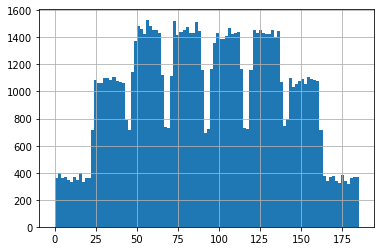

In [34]:
df0['product'].hist(bins=100);

In [35]:
df1['product'].mean()

68.82500000000002

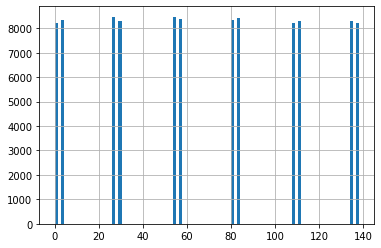

In [36]:
df1['product'].hist(bins=100);

In [37]:
df2['product'].mean()

95.00000000000004

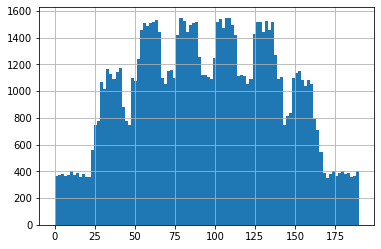

In [38]:
df2['product'].hist(bins=100);

**Вывод по этапу 3**:

В ходе данного этапа были записаны в переменные необходимые значения, расчитан требуемый объем нефти для окупаемости одной скважины, средние значения объема. Средние значения ниже чем требуемая окупаемость. Соответственно для того чтобы разработка нефти окупилась, требуется выбирать скважины

# 4. Расчет прибыли 

Напишем функцию, которая считает прибыль от 200 скважин с самым большим объемом

In [39]:
def calculate_profit(predictions, profit, budget, y_test):
    predictions = predictions.sort_values(ascending = False)
    selected = y_test[predictions.index][:200]
    return selected.sum()*profit - budget    

Напишем функцию, которая считает прибыль от 200 скважин с самым большим объемом

In [40]:
print(('прибыль от 200 скважин с самым большим объемом участка 0 (млрд.руб):'
       ,calculate_profit(pd.Series(predictions0, index = y0_test.index), profit, budget, y0_test )/1e9))
print(('прибыль от 200 скважин с самым большим объемом участка 1 (млрд.руб):'
       ,calculate_profit(pd.Series(predictions1, index = y1_test.index), profit, budget, y1_test )/1e9))
print(('прибыль от 200 скважин с самым большим объемом участка 2 (млрд.руб):'
       ,calculate_profit(pd.Series(predictions2, index = y2_test.index), profit, budget, y2_test )/1e9))

('прибыль от 200 скважин с самым большим объемом участка 0 (млрд.руб):', 3.359141114462179)
('прибыль от 200 скважин с самым большим объемом участка 1 (млрд.руб):', 2.4150866966815108)
('прибыль от 200 скважин с самым большим объемом участка 2 (млрд.руб):', 2.5985717593741113)


# 5. Расчет рисков и прибыли каждого региона 

Применим Bootstrap, найдем 95% доверительный интервал и риск убытков

In [41]:
def calculate_bootstrap(predictions, profit, budget, y_test):
    state = np.random.RandomState(12345)  
    values= []
    values_quantile = []
    for i in range(1000):
        subsample = predictions.sample(n=500, replace=True, random_state=state) 
        values.append(calculate_profit(subsample, profit, budget, y_test))
        subsample = predictions.sample(frac=1, replace=True, random_state=state)   
      


        
    values = pd.Series(values)   
    mean_profit = values.mean()/1e9
    confidence_interval = [values.quantile(0.025),values.quantile(0.975)]    
    risk =  (values < 0).mean() *100  
    return mean_profit, confidence_interval, risk

Найдем требуемые величины для 3-ех участков

In [42]:
mean_profit0, quantile0, risk0 = (calculate_bootstrap
                                  (pd.Series(predictions0, index = y0_test.index), profit, budget, y0_test))

In [43]:
print('Средняя прибыль с участка (0 млрд.руб):', mean_profit0)
print('95-квантиль:', quantile0)
print('риск убытков %:', risk0)

Средняя прибыль с участка (0 млрд.руб): 0.4030751148019766
95-квантиль: [-98609572.6877943, 902798318.3308154]
риск убытков %: 5.7


In [44]:
mean_profit1, quantile1, risk1 = (calculate_bootstrap
                                  (pd.Series(predictions1, index = y1_test.index), profit, budget, y1_test))

In [45]:
print('Средняя прибыль с участка 1 (млрд.руб):', mean_profit1)
print('95-квантиль:', quantile1)
print('риск убытков %:', risk1)

Средняя прибыль с участка 1 (млрд.руб): 0.4315509980918055
95-квантиль: [47510692.67523561, 825319606.2123216]
риск убытков %: 1.5


In [46]:
mean_profit2, quantile2, risk2 = (calculate_bootstrap
                                  (pd.Series(predictions2, index = y2_test.index), profit, budget, y2_test))

In [47]:
print('Средняя прибыль с участка 2 (млрд.руб):', mean_profit2)
print('95-квантиль:', quantile2)
print('риск убытков %:', risk2)

Средняя прибыль с участка 2 (млрд.руб): 0.38261847487257467
95-квантиль: [-118181387.31946382, 918271938.2840863]
риск убытков %: 7.5


# 6. Общий вывод

В ходе данной работы по данным о пробах нефти и скважинах в 3-ех регионах требовалось построить модель для определения региона, где добыча нефти принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой Bootstrap.

Работа состояла из следующих шагов:

1. Загрузка и подготовка данных
2. Обучение моделей
3. Подготовка к расчету прибыли
4. Подготовить функцию для расчета прибыли по выбранным скважинам
5. Посчитать риски и прибыль для полученного объема

В ходе первого этапа были загружены необходимые библиотеки и данные. Было определено, что значений NAN нет, категориальных признаков нет, явных дубликатов нет, все типы соответствуют требуемым. Идентификатор скважины не несет в себе полезной информации, по этому столбец идентификатора был отброшен. 

В ходе обучения модели так была произведена подготовка обучающих и тестовых выборок и масштабирование признаков, обучена линейная регрессия, расчитаны значения RMSE для каждой модели

В ходе третьего этапа были подготовлены необходимые переменные для расчета прибыли

В ходе четвертого этапа была подготовлена функция для расчета прибыли

В ходе пятого этапа были опреелены средняя прибыль с каждого участка, доверительный интервал, а так же вероятность убытков

**Вывод**:

Указаному риску убытков в 2,5% соответствует участок 1 (1.9%)